# Pneumonia XRays Detection

*Course: Machine Learning Projects with TensorFlow 2.0 by Vlad Sebastian Ionescu*

*Data: https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia*

In [1]:
import tensorflow as tf
import IPython.display as display
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os
import pathlib

## 1. Load data

In [2]:
data_dir = pathlib.Path('data/')

image_count = len(list(data_dir.glob('*/*/*.jpeg')))
image_count

5856

In [3]:
class_names = np.array(list(set([item.name for item in data_dir.glob('*/*') if item.name.upper() == item.name])))
class_names

array(['NORMAL', 'PNEUMONIA'], dtype='<U9')

In [4]:
# https://www.tensorflow.org/tutorials/load_data/images

batch_size = 16
img_height = 224
img_width = 224
steps_per_epoch = np.ceil(image_count / batch_size)
autotune = tf.data.experimental.AUTOTUNE

def get_label(file_path):
    # convert the path to a list of path components
    parts = tf.strings.split(file_path, os.path.sep)
    # The second to last is the class-directory
    return 1 if parts[-2] == 'PNEUMONIA' else 0

def decode_img(img):
    # convert the compressed string to a 3D uint8 tensor
    img = tf.image.decode_jpeg(img, channels=3)
    # resize the image to the desired size
    return tf.image.resize(img, [img_height, img_width])

def process_path(file_path):
    label = get_label(file_path)
    # load the raw data from the file as a string
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img, label
 
def prepare_for_training(ds, cache=True, shuffle_buffer_size=1000):
    if cache:
        if isinstance(cache, str):
            ds = ds.cache(cache)
        else:
            ds = ds.cache()
            
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    #ds = ds.repeat()
    ds = ds.batch(batch_size)
    ds = ds.prefetch(buffer_size=autotune)
    return ds
    
def get_dataset(path):
    list_ds = tf.data.Dataset.list_files(os.path.join(str(data_dir), path, '*/*'))
    labeled_ds = list_ds.map(process_path, num_parallel_calls=autotune)
    ds = prepare_for_training(labeled_ds)
    return ds

In [5]:
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10, 10))
    for n in range(16):
        ax = plt.subplot(4, 4, n+1)
        plt.imshow(np.squeeze(image_batch[n]).astype('uint16'))
        plt.title('Pneumonia' if label_batch[n] else 'Normal')
        plt.axis('off')

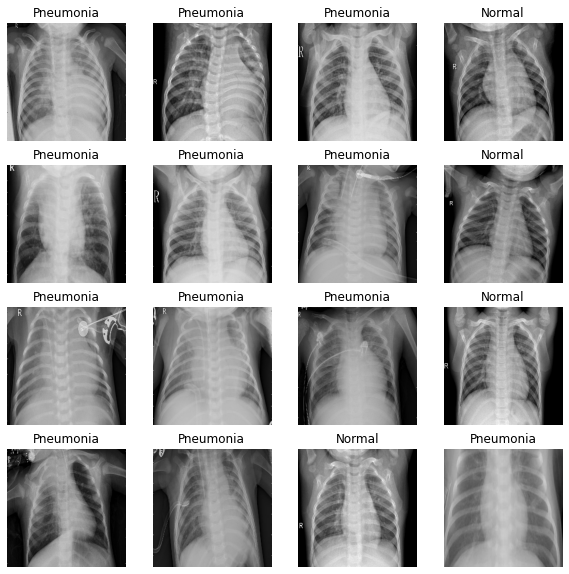

In [6]:
train_ds = get_dataset('train')
image_batch, label_batch = next(iter(train_ds))
show_batch(image_batch.numpy(), label_batch.numpy())

## 2. Baseline model

In [7]:
base_model = tf.keras.applications.Xception(input_shape=(img_width, img_height, 3), 
                                               include_top=False)

In [8]:
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(16, 7, 7, 2048)


In [20]:
base_model.trainable = True

print('Number of layers in the base model: ', len(base_model.layers))

fine_tune_at = 130

for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False
    
base_model.summary()

Number of layers in the base model:  132
Model: "xception"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 111, 111, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 111, 111, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 111, 111, 32) 0           block1_conv1_bn[0][0]            
__________________________________________________

In [10]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
feature_batch_average.shape

TensorShape([16, 2048])

In [11]:
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
prediction_batch.shape

TensorShape([16, 1])

In [12]:
model = tf.keras.models.Sequential([base_model,
                                    global_average_layer,
                                    prediction_layer    
                                    ])

In [13]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
             loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
             metrics=['accuracy'])

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Model)             (None, 7, 7, 2048)        20861480  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 2049      
Total params: 20,863,529
Trainable params: 2,049
Non-trainable params: 20,861,480
_________________________________________________________________


In [15]:
val_ds = get_dataset('val')
loss_val, accuracy_val = model.evaluate(val_ds)

1/1 [==============================] - 0s 1ms/step - loss: 7.4835 - accuracy: 0.5000


In [16]:
test_ds = get_dataset('test')
loss_test, accuracy_test = model.evaluate(test_ds)

39/39 [==============================] - 98s 3s/step - loss: 2.1472 - accuracy: 0.6907


## 3. Fine Tunning

In [17]:
counts = {'NORMAL': 0, 'PNEUMONIA': 1}
for batch in test_ds:
    labels = batch[1]
    for elem in labels:
        class_name = 'PNEUMONIA' if elem==1 else 'NORMAL'
        counts[class_name] += 1
counts

{'NORMAL': 234, 'PNEUMONIA': 391}

In [18]:
counts['NORMAL'] / (counts['PNEUMONIA'] + counts['NORMAL'])

0.3744

In [19]:
epochs = 2
model.fit(train_ds, 
          epochs=epochs,
          validation_data=val_ds,
          verbose=1)

Epoch 1/2
 33/326 [==>...........................] - ETA: 19:00 - loss: 1.0134 - accuracy: 0.7708

KeyboardInterrupt: 

In [ ]:
loss_val, accuracy_val = model.evaluate(val_ds)

In [ ]:
loss_test, accuracy_test = model.evaluate(test_ds)